## This notebook works on the relation extracted triplets made using REBEL for Knowledge Graphs:

- Head (Node)
- Edge (Relation)
- Tail (Node)

In [2]:
!pip install -q neo4j networkx plotly graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.5/293.5 kB 5.2 MB/s eta 0:00:00


In [51]:
import pandas as pd
df_rebel=pd.read_csv('/content/rebel_babelscape_rebel-large.csv')
df_rebel.head()

,url,triplet
0,https://www.equipmentsalesandsurplus.com/v/vsp...,"[{'head': 'table sawing', 'type': 'subclass of..."
1,https://www.equipmentsalesandsurplus.com/v/vsp...,"[{'head': 'table sawing machine', 'type': 'sub..."
2,https://www.equipmentsalesandsurplus.com/v/vsp...,"[{'head': 'table sawing machine', 'type': 'has..."
3,https://texasfurniturehut.com/images/thumbs/00...,"[{'head': 'recliner', 'type': 'subclass of', '..."
4,https://texasfurniturehut.com/images/thumbs/00...,"[{'head': 'leather', 'type': 'subclass of', 't..."


In [55]:
import ast
def str_to_dict(s):
    try:
        return ast.literal_eval(s)
    except (ValueError, SyntaxError):
        return s

# Apply the function to the 'triplet' column
df_rebel['triplet'] = df_rebel['triplet'].apply(str_to_dict)

# Further clean: remove rows with invalid data
df_rebel = df_rebel[df_rebel['triplet'].apply(lambda x: isinstance(x, dict))]

In [56]:
df_rebel

,url,triplet
0,https://www.equipmentsalesandsurplus.com/v/vsp...,"{'head': 'table sawing', 'type': 'subclass of'..."
1,https://www.equipmentsalesandsurplus.com/v/vsp...,"{'head': 'table sawing machine', 'type': 'subc..."
2,https://www.equipmentsalesandsurplus.com/v/vsp...,"{'head': 'table sawing machine', 'type': 'has ..."
3,https://texasfurniturehut.com/images/thumbs/00...,"{'head': 'recliner', 'type': 'subclass of', 't..."
4,https://texasfurniturehut.com/images/thumbs/00...,"{'head': 'leather', 'type': 'subclass of', 'ta..."
...,...,...
2995,https://static.wixstatic.com/media/c3a8ba_1165...,{'head': ''a couple of men standing next to ea...
2996,https://static.wixstatic.com/media/c3a8ba_1165...,{'head': ''a couple of men standing next to ea...
2997,https://cdn.theluxurycloset.com/uploads/opt/pr...,"{'head': 'shoe', 'type': 'has part', 'tail': '..."
2998,https://cdn.theluxurycloset.com/uploads/opt/pr...,"{'head': 'shoes', 'type': 'has part', 'tail': ..."


In [58]:
triplets=df_rebel['triplet'][151:200].tolist()

## Using Neo4j

In [68]:
from neo4j import GraphDatabase

# Connect to Neo4j
uri = "neo4j+s://082c8457.databases.neo4j.io"  # Replace with your Neo4j instance URI
username = "neo4j"
password = "cLcyvTZ8sJ8DH7ohiEZzYPudxFARAu3ic61yDwmKQwU"  # Replace with your Neo4j password
driver = GraphDatabase.driver(uri, auth=(username,password))

def create_nodes_and_relationships(tx, head, type_, tail):
    query = (
        "MERGE (a:head {name: $head}) "
        "MERGE (b: tail {name: $tail}) "
        "MERGE (a)-[r : Relation {type: $type}]->(b)"
    )
    tx.run(query, head=head, type=type_, tail=tail)

#df_rebel_text=df_rebel['triplet'].tolist()
# Open a session and add data
with driver.session() as session:
    for row in triplets:
        session.write_transaction(create_nodes_and_relationships, row['head'], row['type'], row['tail'])

print("Knowledge graph created successfully!")

driver.close()

<ipython-input-68-ee3fc665c600>:21: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(create_nodes_and_relationships, row['head'], row['type'], row['tail'])


Knowledge graph created successfully!


## Now, after opening the neo4j instance, runn the Cypher query

### MATCH (n)-[r]->(m)
### RETURN n, r, m

Press play button on the screen


## NetworkX

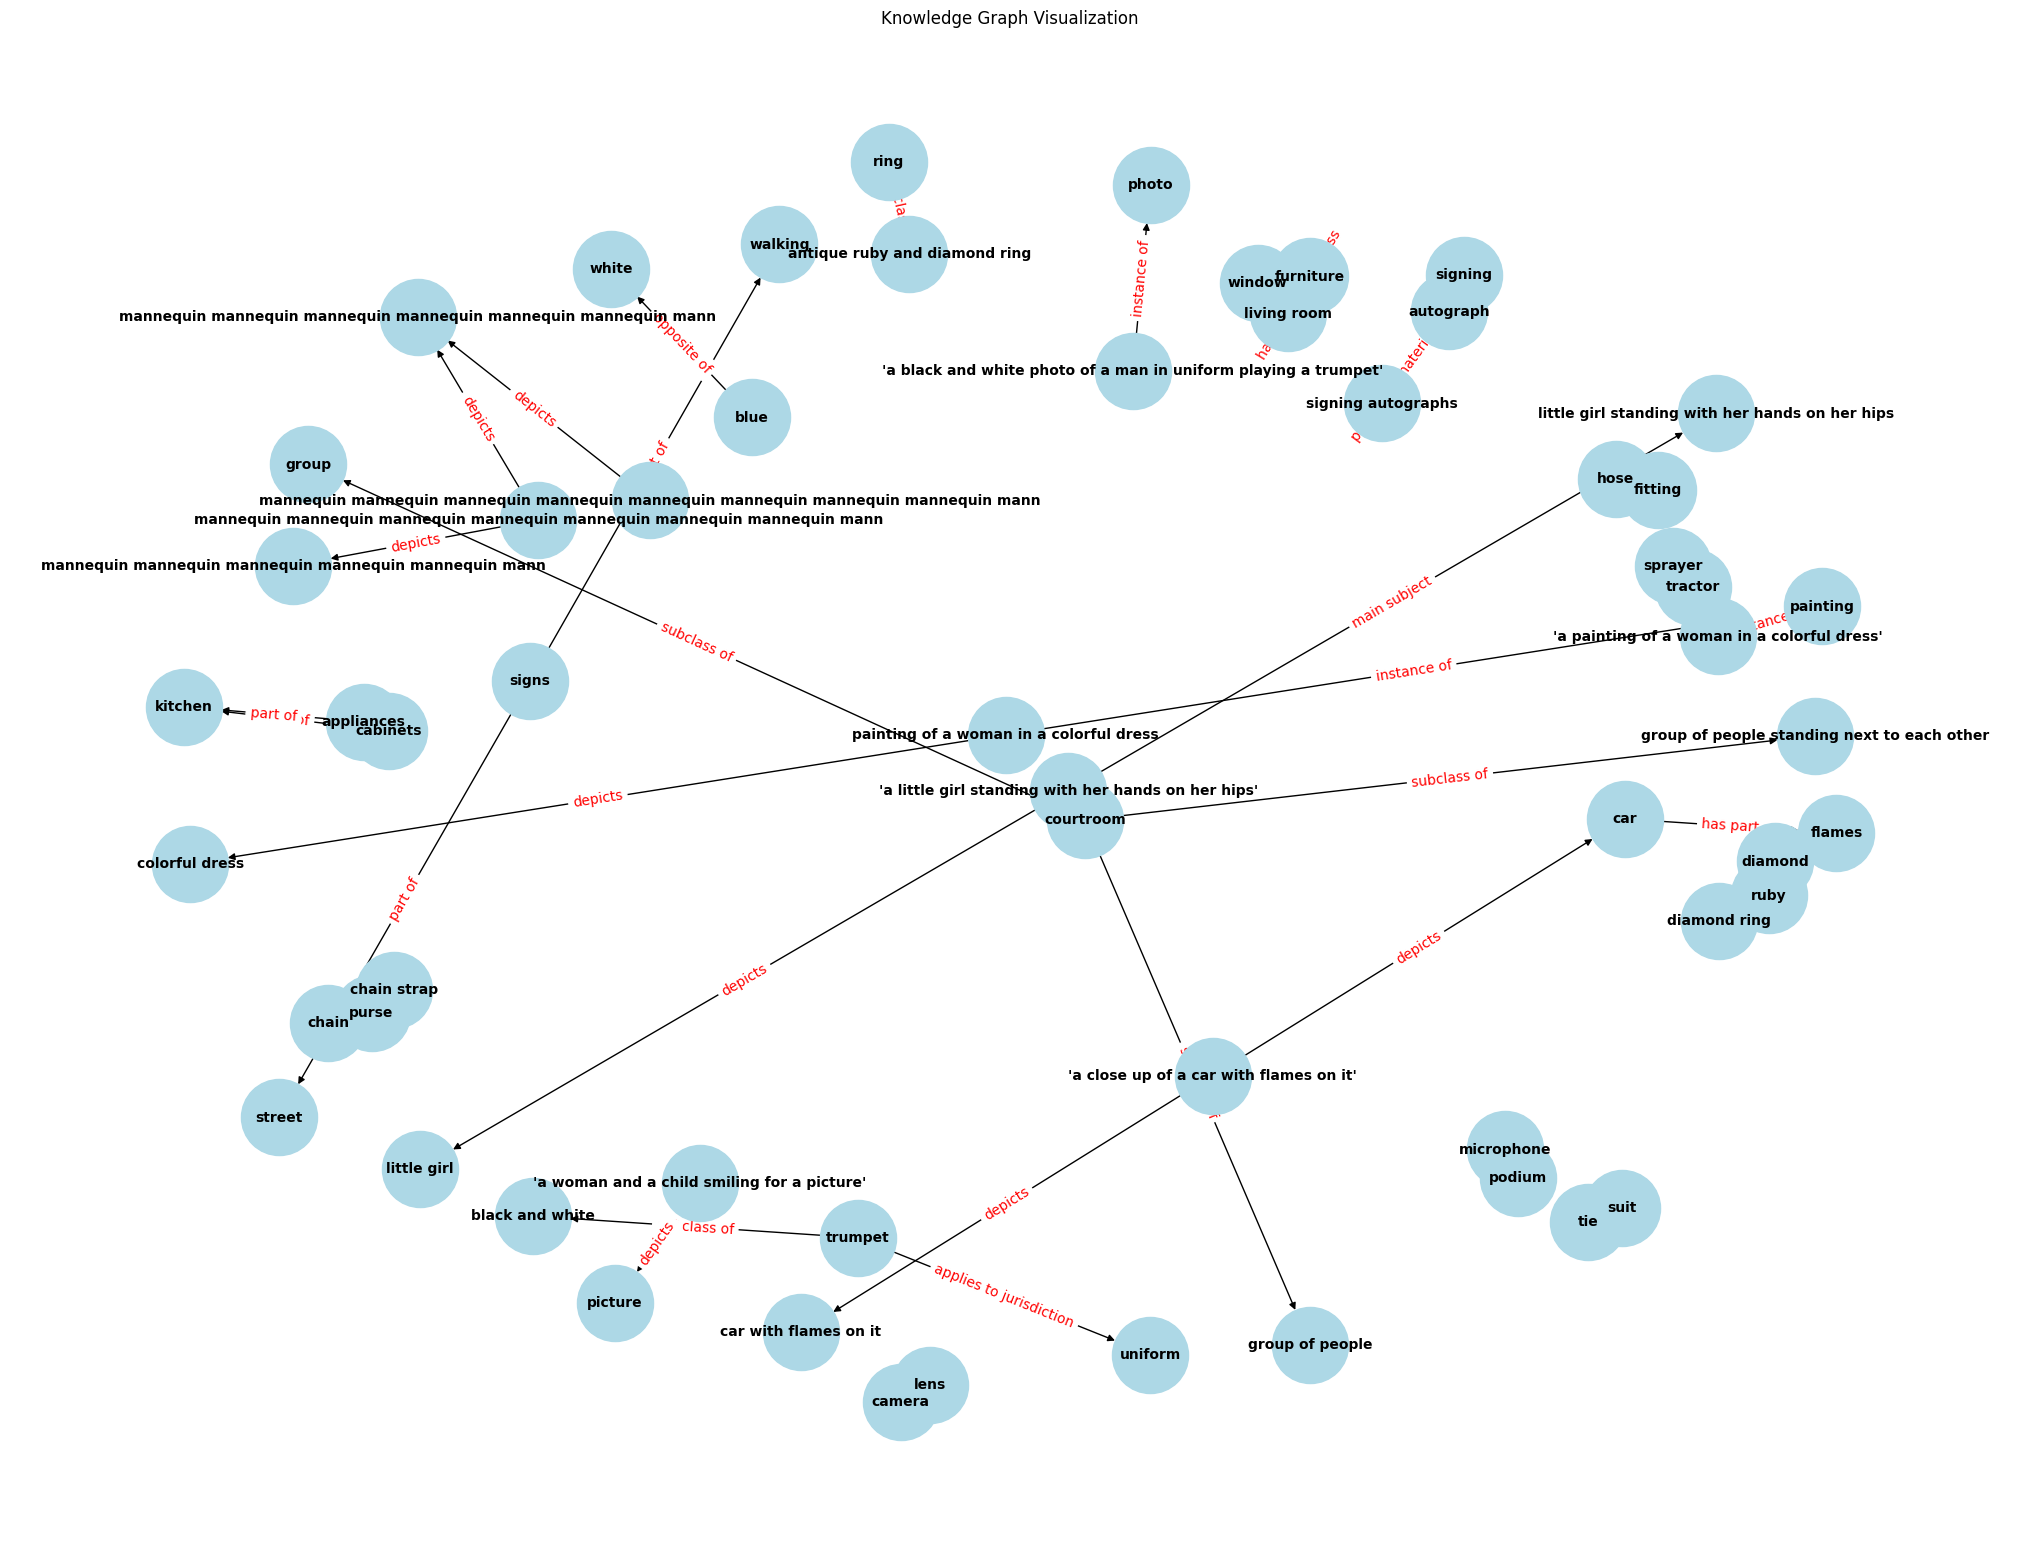

In [67]:
import networkx as nx
import matplotlib.pyplot as plt

G=nx.DiGraph()

# Add edges to the graph
for row in triplets:
    if isinstance(row, dict):  # Ensure the item is a dictionary
        G.add_edge(row['head'], row['tail'], label=row['type'])
# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes
labels = nx.get_edge_attributes(G, 'label')

plt.figure(figsize=(20, 15))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_color='red')

plt.title('Knowledge Graph Visualization')
plt.show()

## Plotly with NetworkX Di-graph
### Layout is spring- you can change to different distribution
- Circular- pos = nx.circular_layout(G)
- Kamada-Kawai Layout- pos = nx.kamada_kawai_layout(G)
- Shell Layout- pos = nx.shell_layout(G)
- Spectral Layout- pos = nx.spectral_layout(G)


In [84]:
import plotly.graph_objects as go
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph
for record in triplets:
    G.add_edge(record['head'], record['tail'], label=record['type'])

pos = nx.spring_layout(G)

# Extract edge labels
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=2, color='#888'),
    hoverinfo='none',
    mode='lines')

config = {
    'scrollZoom': True,       # Enable scroll to zoom
    'modeBarButtonsToRemove': [ 'select2d', 'lasso2d',
                                'autoScale2d',
                               'resetScale2d', 'hoverClosestCartesian',
                               'hoverCompareCartesian', 'toggleSpikelines'],
    'displaylogo': True      # Hide the Plotly logo
}


# Extract node labels
node_x = []
node_y = []
for node in pos:
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    text=[node for node in G.nodes()],
    textposition="bottom center",
    hoverinfo='text',
    marker=dict(
        showscale=False,
        colorscale='YlGnBu',
        size=30,
        line_width=1
    )
)

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='Network graph made with Plotly',
                titlefont_size=32,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Python code: <a href='https://plotly.com/python/network-graphs/'> link</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False,showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False,showticklabels=False))
                )

fig.update_layout(
    dragmode='zoom',  # Set default dragmode to zoom
    modebar_add=['zoomIn2d', 'zoomOut2d', 'zoom2d','zoomIn2d', 'zoomOut2d']
)

fig.show(config=config)


## Grpahviz

In [85]:
from graphviz import Digraph

# Create a Digraph object
dot = Digraph()

# Add nodes and edges to the Digraph
for record in triplets:
    dot.node(record['head'])
    dot.node(record['tail'])
    dot.edge(record['head'], record['tail'], label=record['type'])

# Render and display the graph in the notebook
dot.render('knowledge_graph', view=True)


'knowledge_graph.pdf'